# Summary

This notebook contains the code needed to visualise the gradient activations of the model's output with respect to a particular layer's output. It is used to  identify the parts of an input image that most impact the output of the model.

Model used (trial_5):
- Model: CBAM U-Net
- Loss: Weighted IOU loss
- Dataset: Augmented, Patched dataset
 
Layer chosen:
- decoder_depth4, which is the first convolutional block in the upsampling (decoding) portion of the U-Net architecture

**Note**: This notebook was executed on Kaggle due to the lack of local computational resources.

In [1]:
import os 
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '..', '..', 'seg_grad_cam'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'attention_unet'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'dataloader'))

from seg_grad_cam import *
from visualise_sgc import *

from cbam_unet import *

from load_data import *

%load_ext autoreload
%autoreload 2

# 1. Get images to visualise

In this case, we would be visualising for all images in the validation data set.

In [23]:
# Read in images from directory and create tf.data.Dataset
# Get file names

imgs_dir = os.path.join(os.getcwd(), '..', '..', 'datasets/train/image')
gts_dir = os.path.join(os.getcwd(), '..', '..', 'datasets/train/groundtruth')

# Since using iou loss, need to one hot encode the groundtruth images
original_dataset = create_dataset(imgs_dir, gts_dir, one_hot = True)

print(f'Loaded data set: {original_dataset}')

Loaded data set: <_MapDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>


In [24]:
# Split into train and validation split
# Augmentation is only performed on the training split

# Shuffle the dataset
# Seed of 1 for reproducibility
train_prop = 0.9
num_samples = len(original_dataset)

# seed and reshuffle_each_iteration = False to prevent reshuffling after each iteration of dataset for reproducibility
seed = 1
shuffled_dataset = original_dataset.shuffle(buffer_size = num_samples, seed = seed, reshuffle_each_iteration = False)  
print(f'Shuffled data set: {shuffled_dataset}, no. of samples: {len(shuffled_dataset)}')

train_size = int(train_prop*num_samples)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)
print(f'Train data set: {train_dataset}, no.of samples: {len(train_dataset)}')
print(f'Validation data set: {val_dataset}, no.of samples: {len(val_dataset)}')

Shuffled data set: <_ShuffleDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>, no. of samples: 100
Train data set: <_TakeDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>, no.of samples: 90
Validation data set: <_SkipDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>, no.of samples: 10


In [25]:
# Visualising the validation images hence, only patch the validation images
# Patch the images
len_before_patch = len(val_imgs_dataset)
val_patched_ds = generate_patches(val_dataset, (128,128), 0, True, False)
len_after_patch = len(val_patched_ds)

# Determine number of patches per image
num_patch_per_image = len_after_patch/len_before_patch
print(f'Number of patches per image: {int(num_patch_per_image)}')

val_patched_imgs_ds = val_patched_ds.map(lambda img, gt: img)
val_patched_gts_ds = val_patched_ds.map(lambda img, gt: gt)

# Batch patched dataset baed on number of patches per image to batch per image
val_patched_imgs_ds = val_patched_imgs_ds.batch(int(num_patch_per_image))
val_patched_gts_ds = val_patched_gts_ds.batch(int(num_patch_per_image))

# Only retrieve validation image 4 to visualise due to computational resources
val_img4 = list(iter(val_patched_imgs_ds))[3]
val_gt4 = list(iter(val_patched_gts_ds))[3]
print(f'Number of patches for validation image 4: {val_img4.shape[0]}')

Number of patches per image: 9
Number of patches for validation image 4: 9


# 2. Prepare model

Load in model, build and load pre-trained weights

In [26]:
# Determine class weights which will be used in model later on
road_pixel_prop, bg_pixel_prop = get_class_weights(imgs_dir, gts_dir)
print(f'Road pixel proportions: {road_pixel_prop}, Background pixel proportions: {bg_pixel_prop}')

road_weight = 1./road_pixel_prop
bg_weight = 1./bg_pixel_prop
print(f'Road weight: {road_weight}, Background weight: {bg_weight}')

Road pixel proportions: 0.225259875, Background pixel proportions: 0.7747401249999997
Road weight: 4.439317033271016, Background weight: 1.2907554000768973


In [27]:
# Build the model graph to freely access output of each layer
input_shape = (None, 128, 128, 3)
cbam_unet_model = CBAM_UNet(input_shape, bg_weight, road_weight, 'weighted_iou')
inputs = tf.keras.Input(shape=input_shape[1:])
cbam_unet_model.call(inputs)
    
cbam_unet_model.built = True
cbam_unet_model.load_weights('trial5_weights.h5') # include later

In [28]:
print(cbam_unet_model.get_layer("decoder_depth4").output)
print(cbam_unet_model.get_layer("output_block").output)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='decoder_depth4/conv_layer2/Relu:0', description="created by layer 'decoder_depth4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None), name='output_block/conv2d_37/Sigmoid:0', description="created by layer 'output_block'")


# 3. Get gradient activation visualisations

This class takes in an image of our choice, the class that we want to target, a receptive field to search in, the output layer and the layer from which we want to visualise the gradient of. 

- Initialisation parameters for SegGradCam:

    - input_model: cbam_unet_model with loaded weights
    - image: actual image to produce gradient visualisation for
    - gt: actual gt of image gradient visualisation is produced for
    - cls: 0 or 1; depending on which class to produce gradient visualisation for 
    - prop_to_layer: layer to get feature maps of interest
    - prop_from_layer: final layer with sigmoid activation
    - roi: Not given as an argument to use default value, where the gradients are explained for the entire image
    - normalize: True; to normalise the gradients after the Seg Grad CAM is generated
    - abs_w = False; whether to use absolute function on alpha_c
    - posit_w = False; whether to use relu on alpha_c, to clip negative gradients associated with the class

<p></p>

- Additional notes:

    - alpha_c: Weight given to chosen class c to denote its importance
    - y_c: Logits for the chosen class c

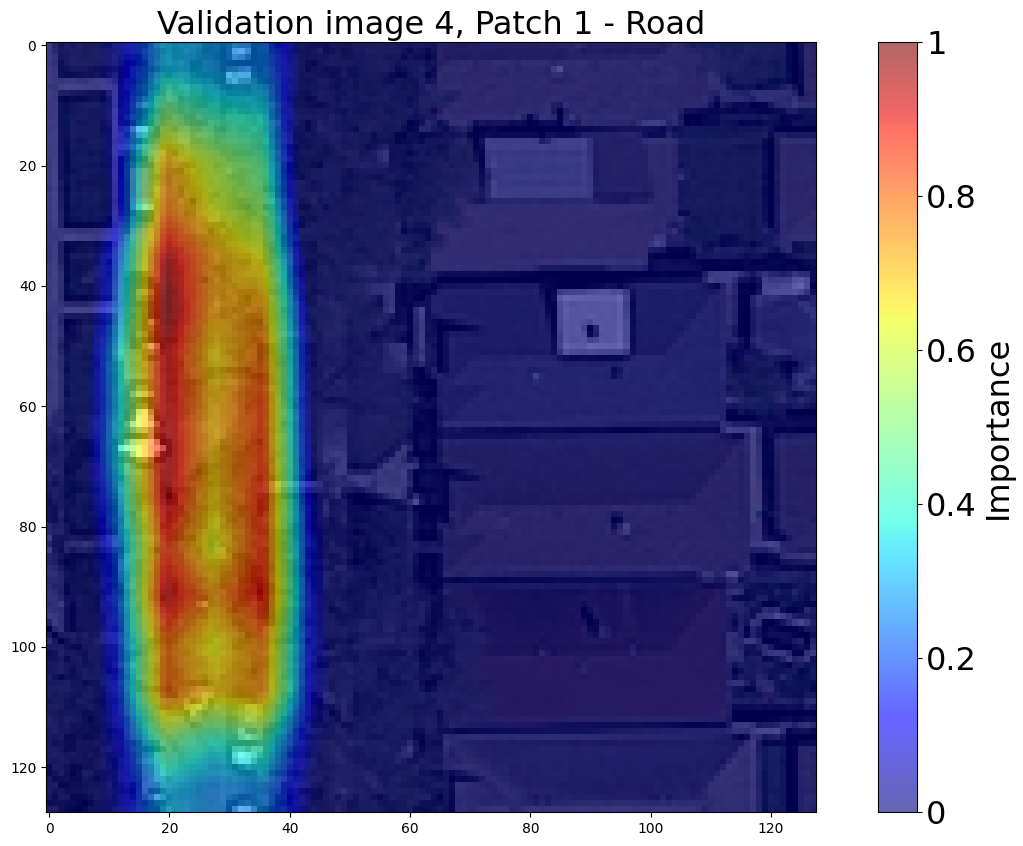

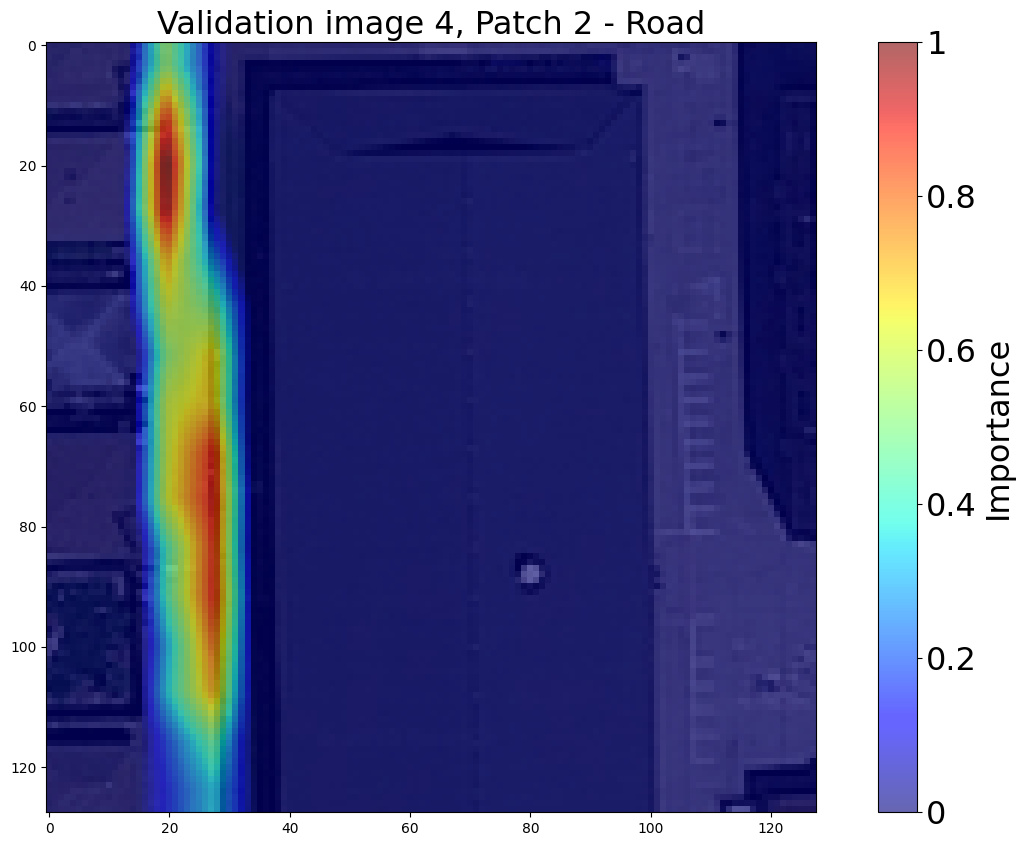

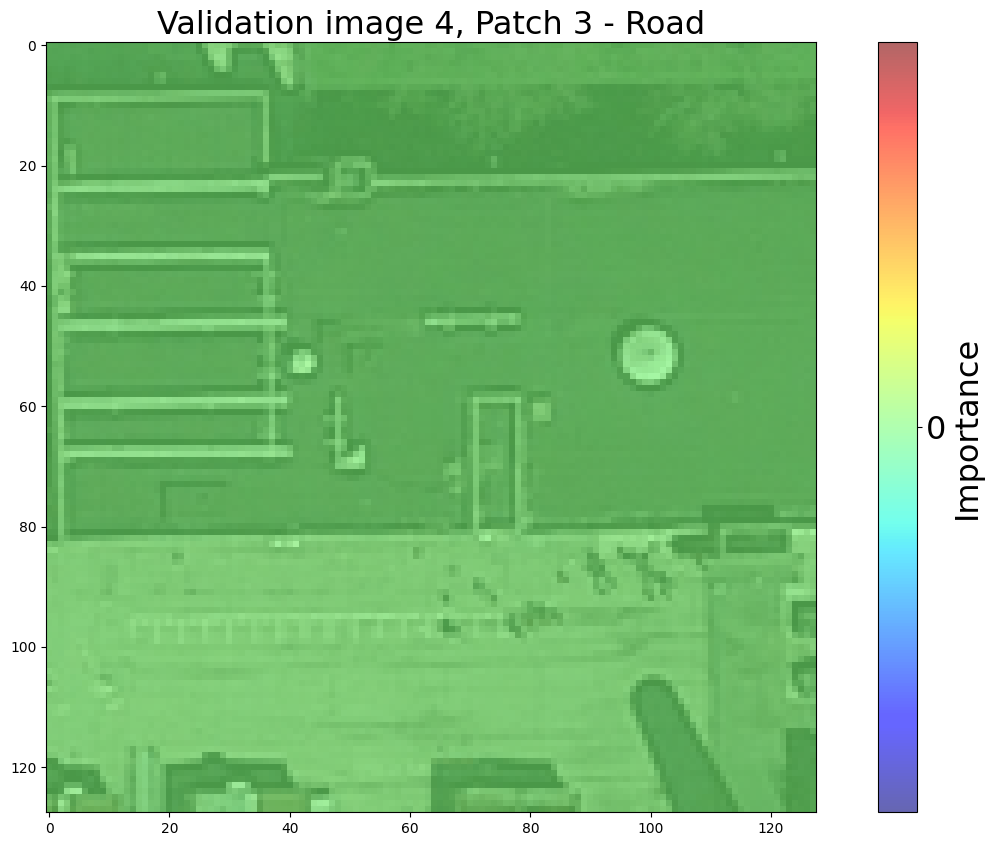

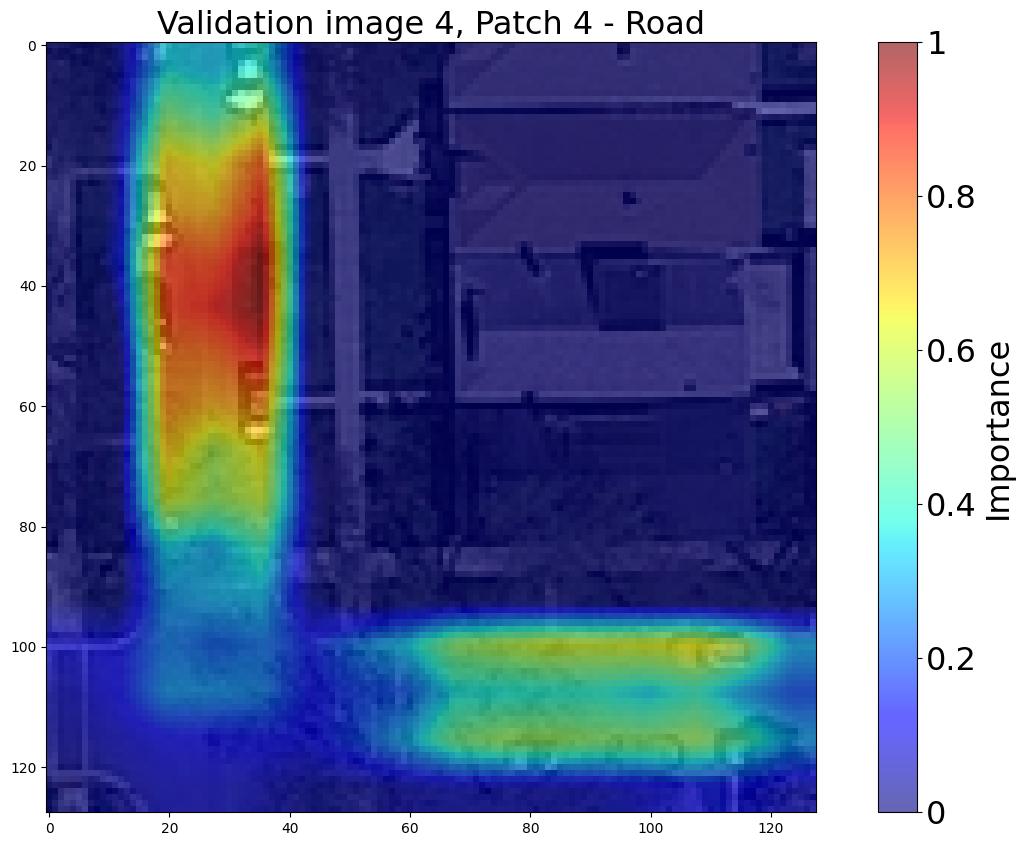

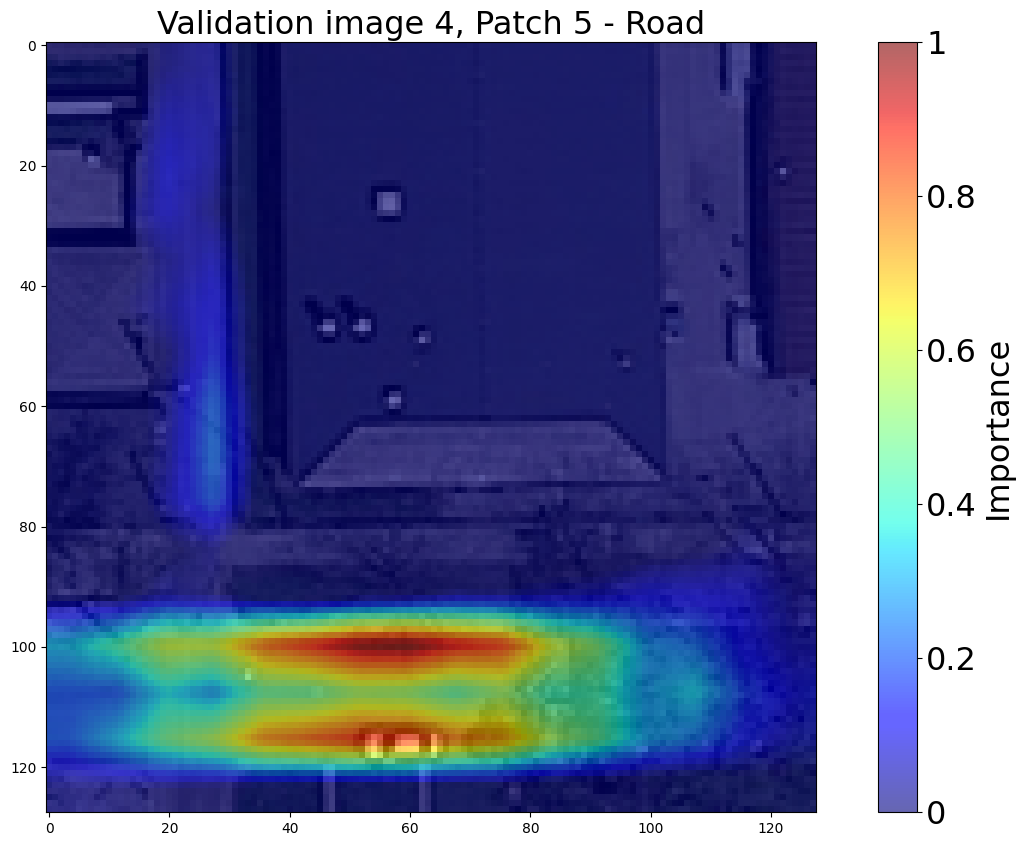

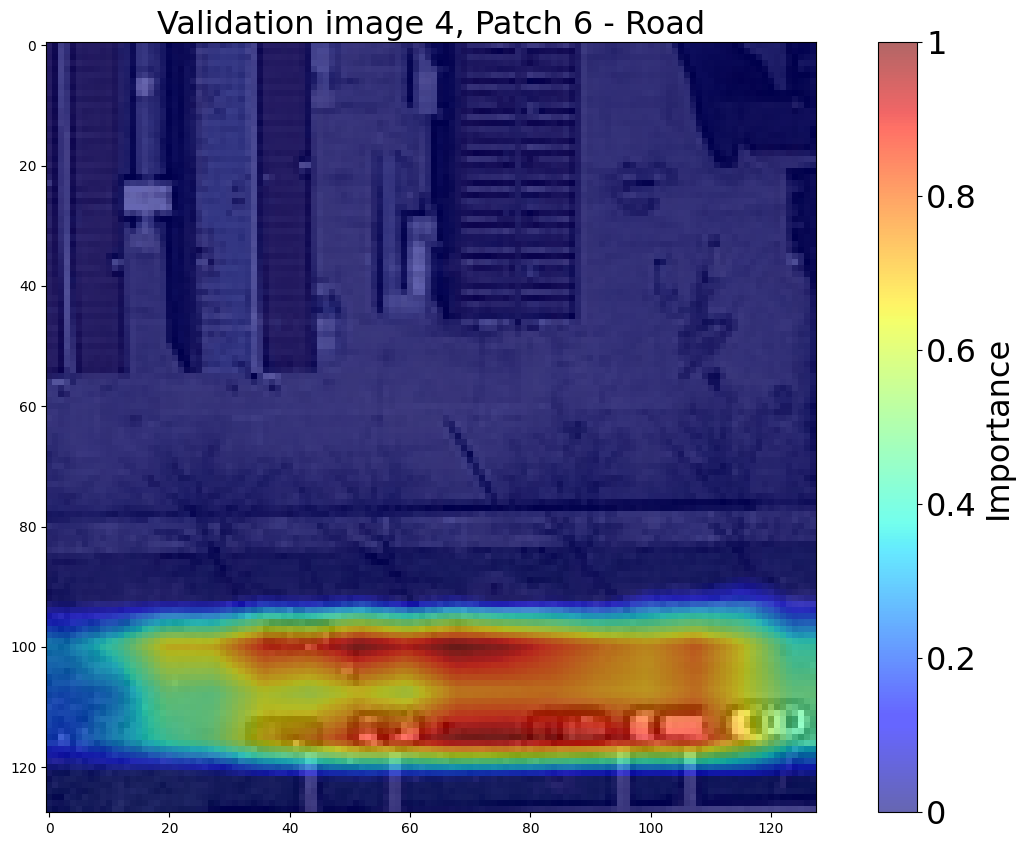

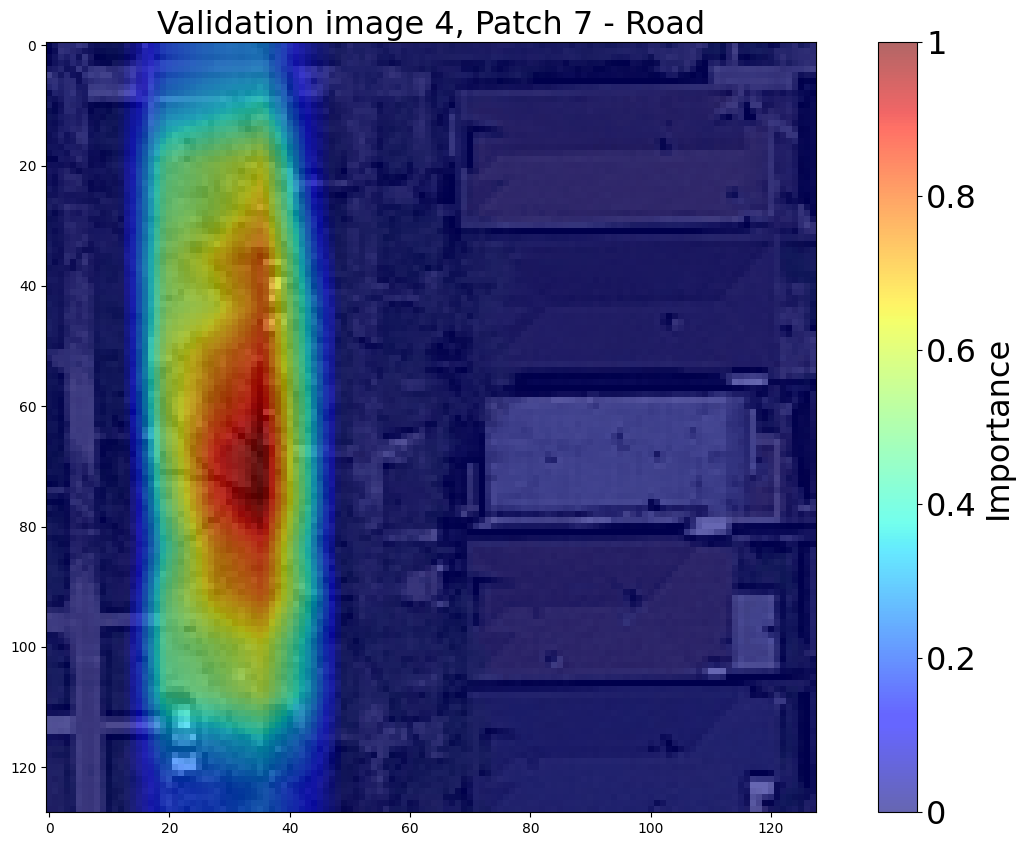

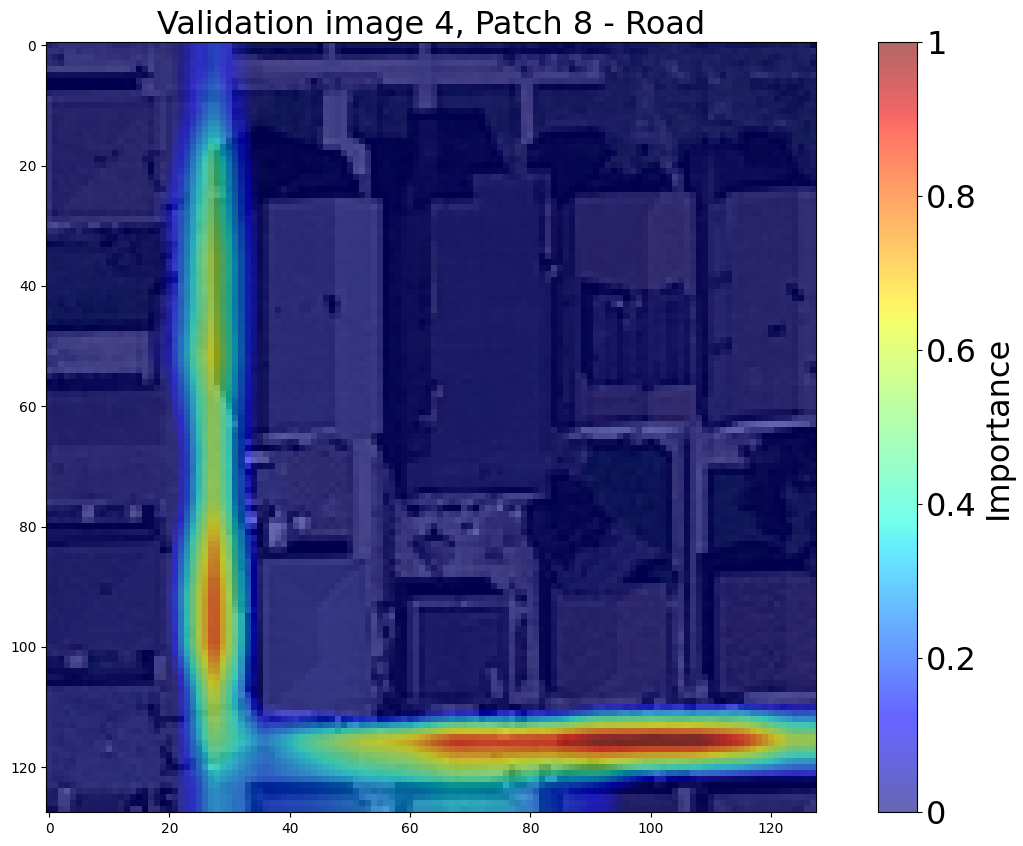

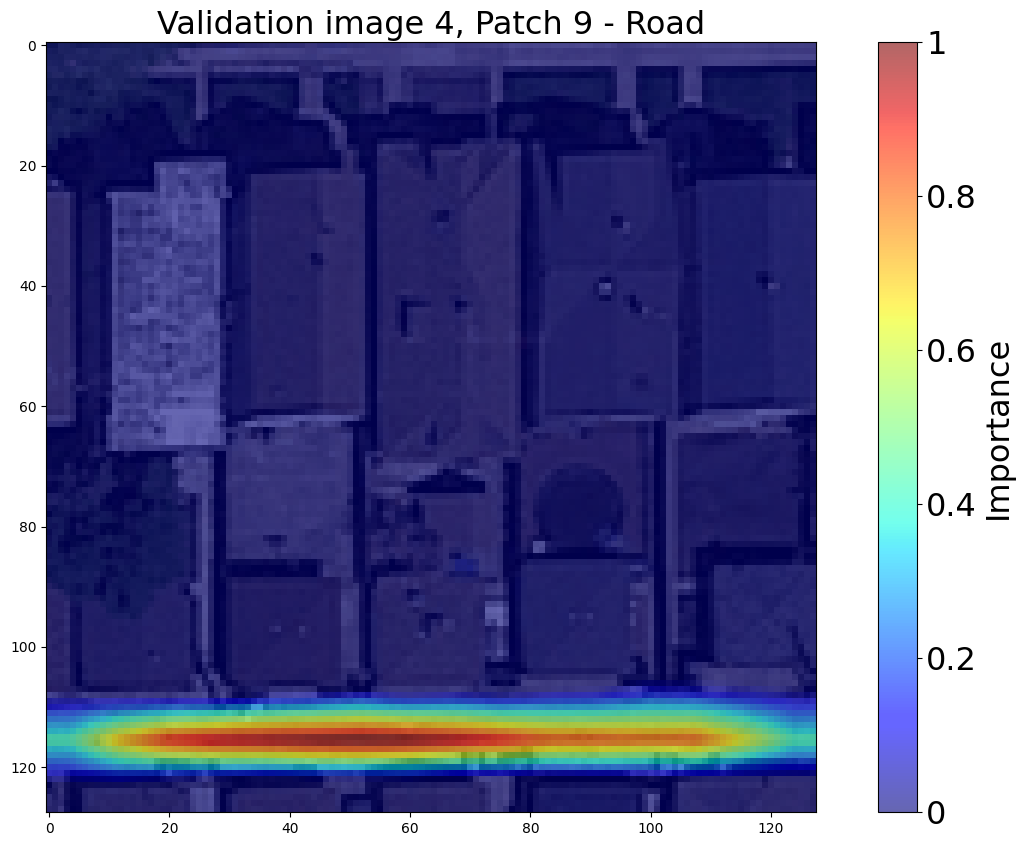

In [29]:
num_patches = len(val_img4)

for i in range(num_patches): 

    gt = val_gt4[i]
    img = val_img4[i]

    # Build the model graph to freely access output of each layer
    input_shape = (None, 128, 128, 3)
    cbam_unet_model = CBAM_UNet(input_shape, bg_weight, road_weight, 'weighted_iou')
    inputs = tf.keras.Input(shape=input_shape[1:])
    cbam_unet_model.call(inputs)

    cbam_unet_model.built = True
    cbam_unet_model.load_weights('trial5_weights.h5') # include later
    
    # Initialise seg_grad_cam class
    # seg_grad_cam = SegGradCAM(...)
    seg_grad_cam = SegGradCAM(cbam_unet_model, img, gt, 1, 'decoder_depth4', 'output_block')

    # Get activation map
    activation_map = seg_grad_cam.SGC()

    # Get plot
    seg_grad_cam_plot = SegGradCAMplot(seg_grad_cam)
    seg_grad_cam_plot.roi.image = seg_grad_cam_plot.image
    seg_grad_cam_plot.explainBase(f'Validation image 4, Patch {i+1} - Road', '', 'grad_activations' , f'trial5_val_img4_patch_{i+1}_road') # .explainBase(<plot_main_title>, <plot_bias_title>, <filename_to_save>)

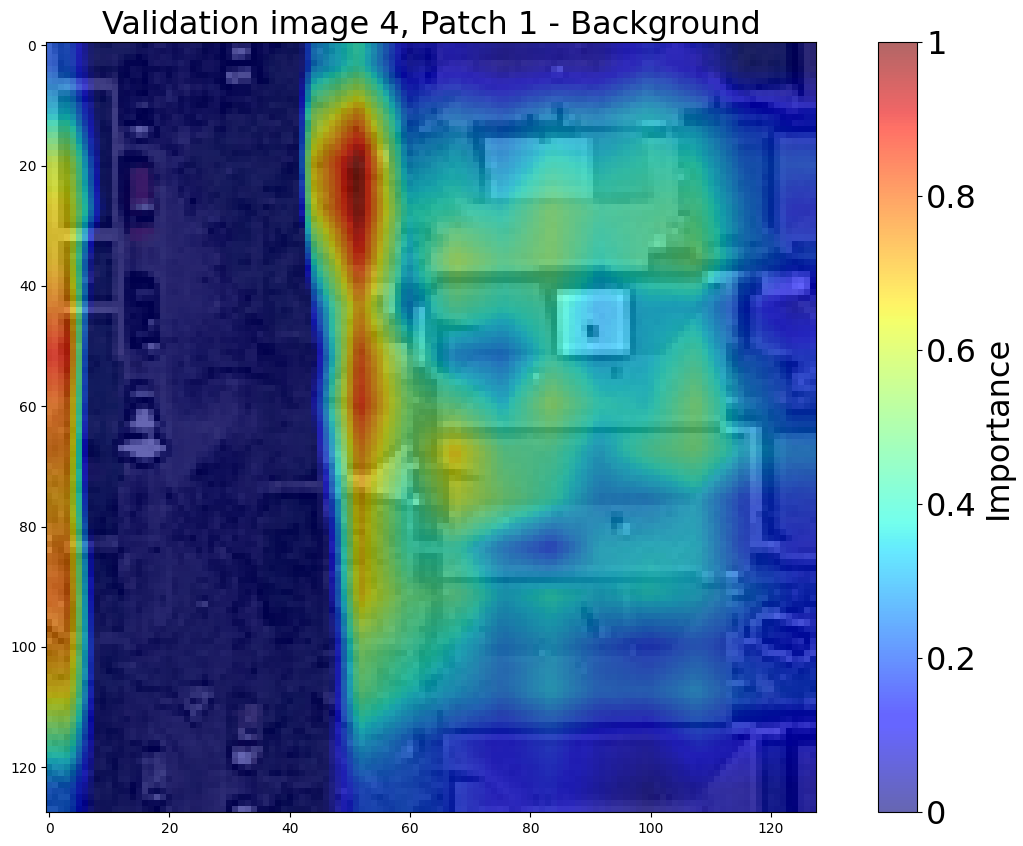

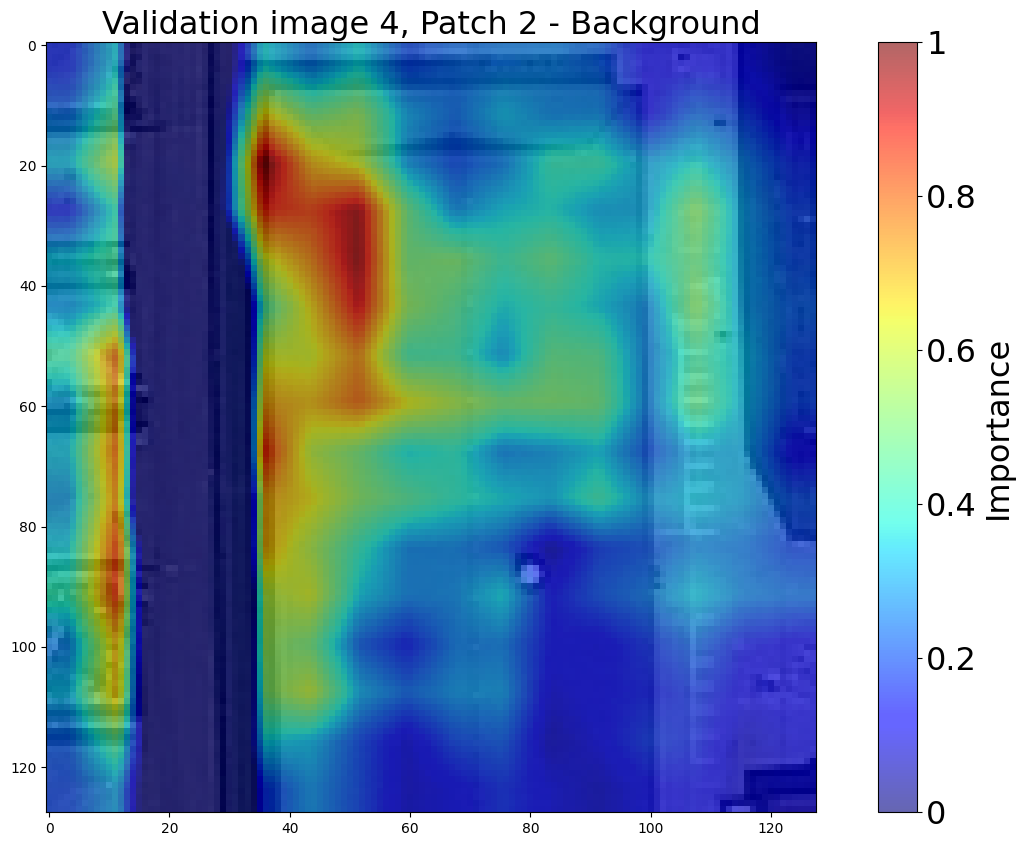

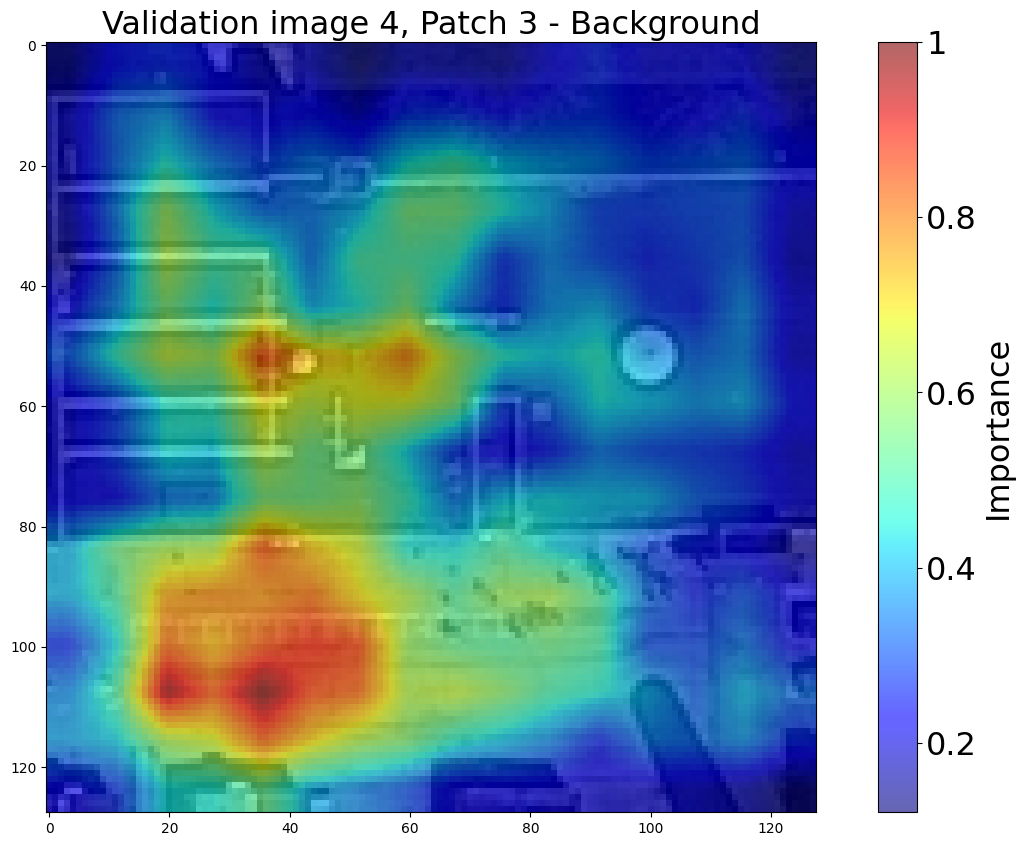

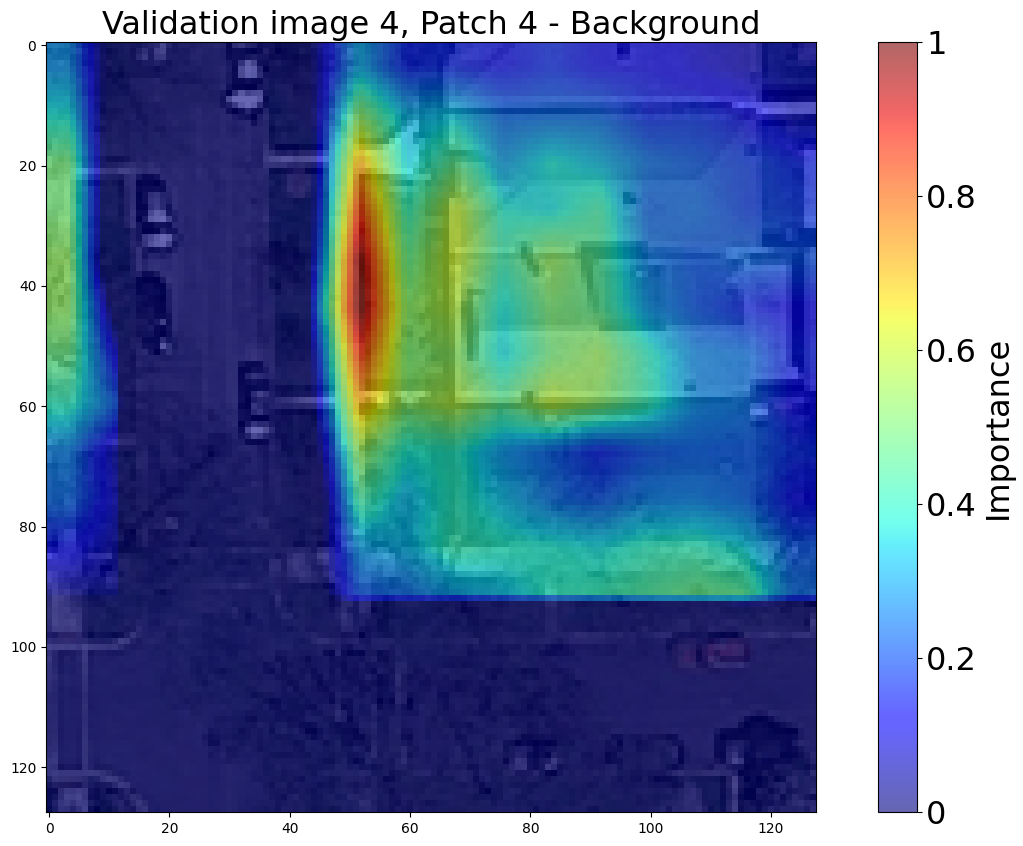

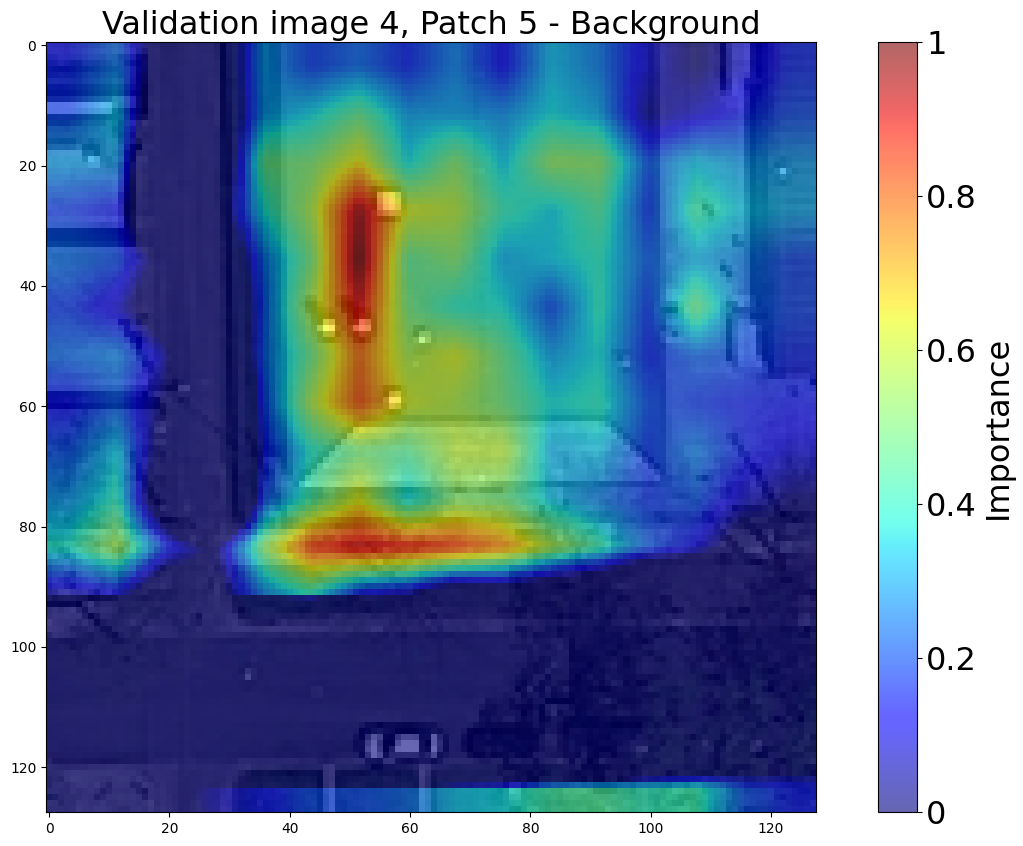

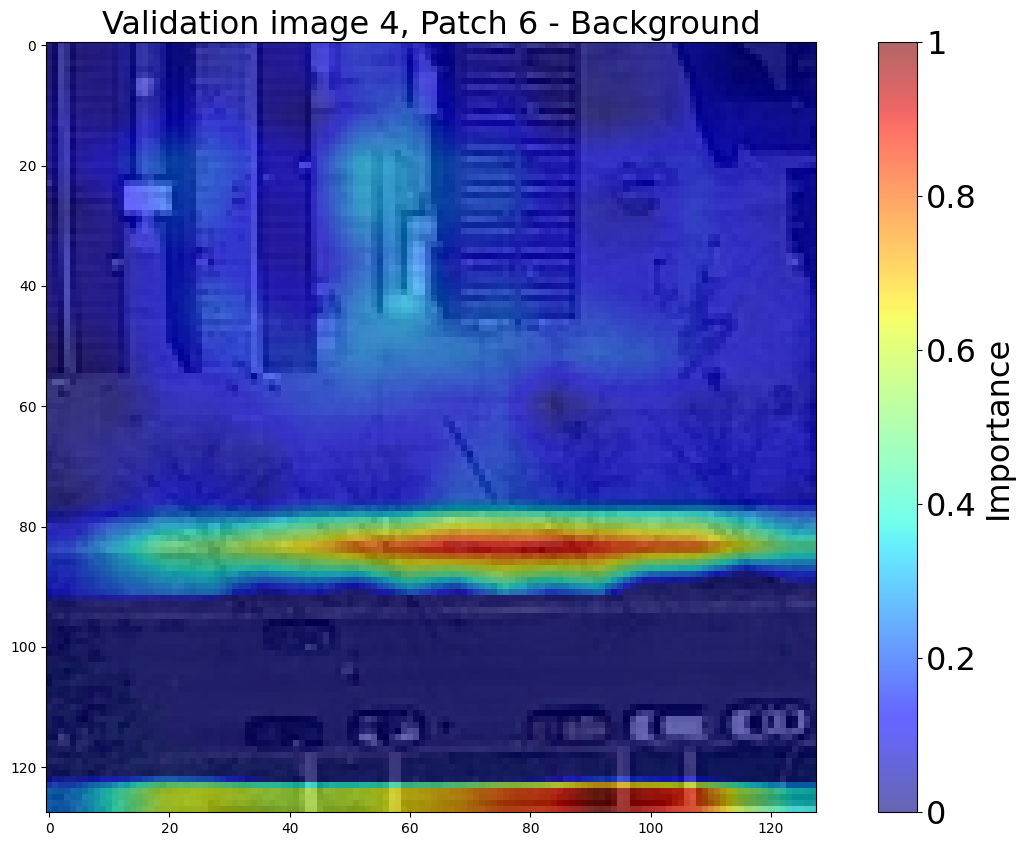

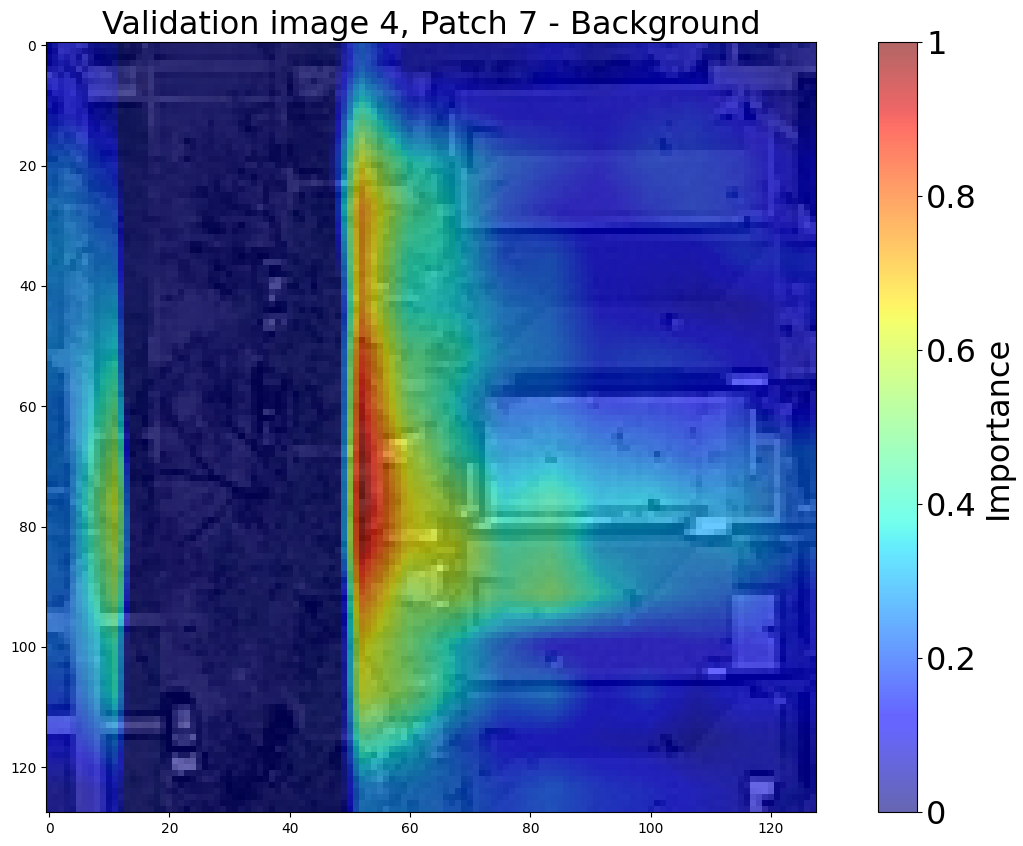

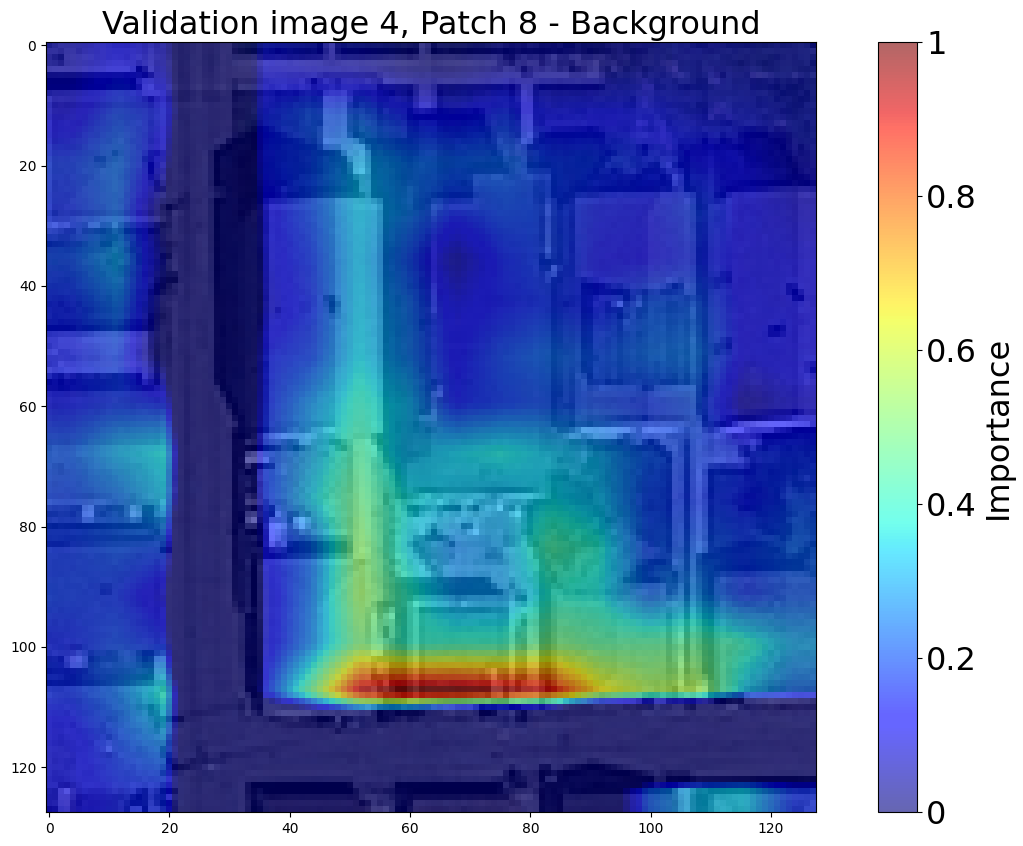

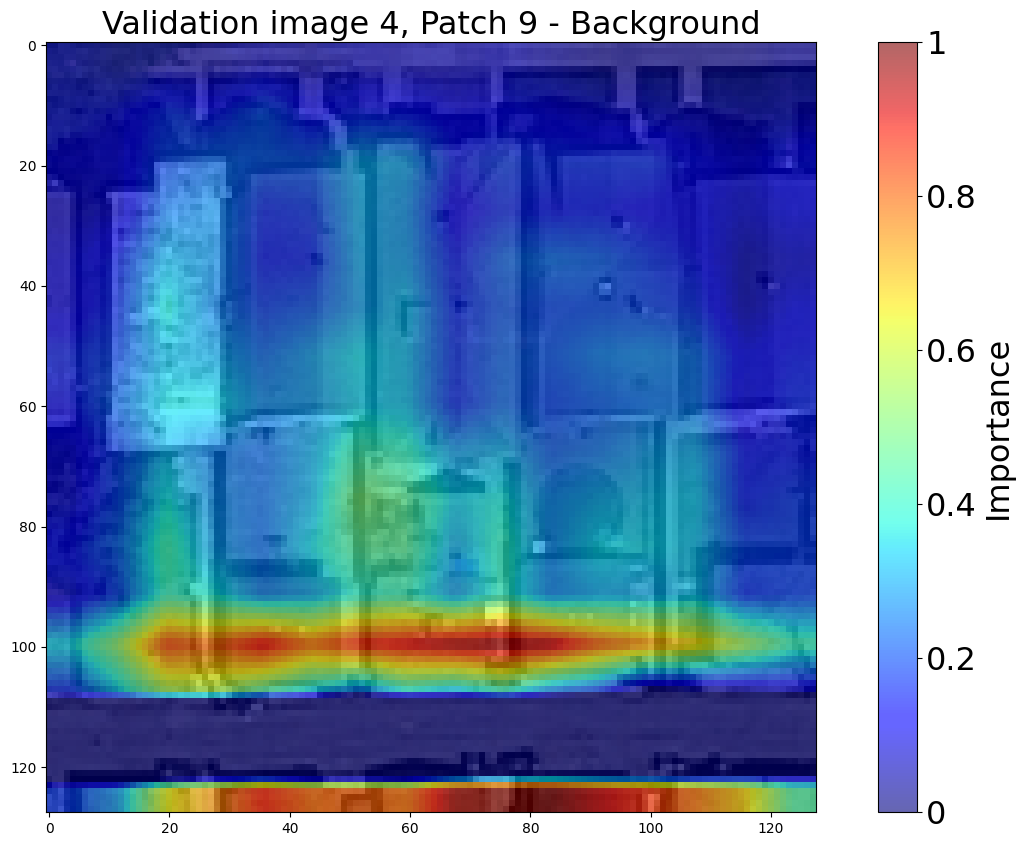

In [30]:
num_patches = len(val_img4)

for i in range(num_patches): 

    gt = val_gt4[i]
    img = val_img4[i]

    # Build the model graph to freely access output of each layer
    input_shape = (None, 128, 128, 3)
    cbam_unet_model = CBAM_UNet(input_shape, bg_weight, road_weight, 'weighted_iou')
    inputs = tf.keras.Input(shape=input_shape[1:])
    cbam_unet_model.call(inputs)

    cbam_unet_model.built = True
    cbam_unet_model.load_weights('trial5_weights.h5') # include later
    
    # Initialise seg_grad_cam class
    # seg_grad_cam = SegGradCAM(...)
    seg_grad_cam = SegGradCAM(cbam_unet_model, img, gt, 0, 'decoder_depth4', 'output_block')

    # Get activation map
    activation_map = seg_grad_cam.SGC()

    # Get plot
    seg_grad_cam_plot = SegGradCAMplot(seg_grad_cam)
    seg_grad_cam_plot.roi.image = seg_grad_cam_plot.image
    seg_grad_cam_plot.explainBase(f'Validation image 4, Patch {i+1} - Background', '', 'grad_activations' , f'trial5_val_img4_patch_{i+1}_background') # .explainBase(<plot_main_title>, <plot_bias_title>, <filename_to_save>)